# Benchmark Models

In [2]:
import turbo as tb
import rul_dataframe as rd
import plots as pl
import labeling as lb
import preprocessing as pre
import classification as cls
import variational_autoencoder as vae_class

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn import linear_model, svm
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

from sklearn import ensemble

In [3]:
preproc = pre.Preprocessing()
classy = cls.Classification()
label = lb.Labeling()

In [4]:
def training_validation_split(X, Y, groupshufflesplit, groups, verbose = False):
    for itrain, ival in groupshufflesplit.split(X, Y, groups = groups):
        Xtrain = X.iloc[itrain].copy()
        Ytrain = Y.iloc[itrain].copy()
        Xval = X.iloc[ival].copy()
        Yval = Y.iloc[ival].copy()
        if verbose:
            print(f'Training data ids {groups[itrain].unique()}')
            print(f'Validation data ids {groups[ival].unique()}')
    return Xtrain, Ytrain, groups[itrain], Xval, Yval, groups[ival]

In [5]:
def s_score(Y, Yhat, a1 = 10, a2 = 13):
    s = 0.0
    for i in range(len(Y)):
        d = Yhat[i] - Y[i]
        if d < 0:
            s = s + np.exp(-d/a1) - 1
        else:
            s = s + np.exp(d/a2) - 1
    return s

def l_score(Y, Yhat):
    s = 0.0
    for i in range(len(Y)):
        d = (Yhat[i] - Y[i])**2
        if Y[i] < 50:
            s = s + 2 * d
        else:
            s = s + 0.5 * d
    return s/len(Y)

def evaluate(Y, Yhat, label = 'Test', verbose = False):
    if label == 'Test':
        rsme = np.sqrt(mean_squared_error(Y, Yhat))
        r2 = r2_score(Y, Yhat)
        s = s_score(Y, Yhat)
        l = l_score(Y, Yhat)
        if type(s) == np.ndarray:
            s = s[0]
        if type(l) == np.ndarray:
            l = l[0]
        if verbose:
            print(f'{label} set RSME = {rsme}, S = {s}, L= {l}, R2 = {r2}')
        return rsme, s, l, r2
    else:
        rsme = np.sqrt(mean_squared_error(Y, Yhat))
        r2 = r2_score(Y, Yhat)
        if verbose:
            print(f'{label} set RSME = {rsme}, R2 = {r2}')
        return rsme, r2

In [44]:
method = 'lm'
lag = 2
dpoly = 1
for dataset in [1]:
    path = f'scores/shallow_{method}_FD00{dataset}_lag_{lag}_poly_{dpoly}'
    results = pd.DataFrame(columns=['dataset', 'label', 'method', 'RSME_tr','R2_tr', 'RSME_v','R2_v','RSME_te', 'R2_te'])
    tr, te, rl = tb.getTFDataset(set = dataset)
    tb.addTFlinear(tr, te, rl)
    tr_df = rd.RUL_DataFrame(df = tr, label_cols = ['linear'])
    te_df = rd.RUL_DataFrame(df = te, label_cols = ['linear'])
    if dataset in [1,3]:
        preproc.drop_zero_variance(rul_df = tr_df, rul_df_test = te_df)
        preproc.scale(rul_df = tr_df, rul_df_test = te_df, scale = 'std')
    elif dataset in [2, 4]:
        classy.fit_kmeans(rul_df = tr_df, rul_df_test = te_df, colname = 'kmeans')
        preproc.one_hot_encode(rul_df = tr_df, rul_df_test = te_df, c_col = 'kmeans')
        preproc.c_drop_zero_variance(rul_df = tr_df, rul_df_test = te_df , c_cols = tr_df.categ_cols)
        preproc.c_scale(rul_df = tr_df, rul_df_test = te_df , c_cols = tr_df.categ_cols, scale = 'std')
    # Optional smoothing
    preproc.exponential_smooth(tr_df, 0.1)
    preproc.exponential_smooth(tr_df, 0.1)
    preproc.delete_first_n(tr_df, 9)
    labels = pd.read_csv(f'labels/FD00{dataset}')
    label_cols = ['linear', 'piecewise_optimized', 'piecewise_125', 'descriptive', 'spearman', 'rec_error']
    if not labels.shape[0] == tr_df.df.shape[0]:
        print(f'Labels and Data do not have same length. Dataset FD00{dataset}')
    temp = pd.concat([tr_df.df, labels], axis=1)
    training_data_with_labels = rd.RUL_DataFrame(df = temp, data_cols = tr_df.data_cols, categ_cols = tr_df.categ_cols, label_cols = ['linear', 'piecewise_optimized', 'piecewise_125', 'descriptive', 'spearman',
                                                            'rec_error'])
    if lag > 0:
        preproc.lag_data(training_data_with_labels, cols = training_data_with_labels.data_cols + training_data_with_labels.categ_cols, lag = lag, categories = True)
        preproc.lag_data(te_df, cols = te_df.data_cols + te_df.categ_cols, lag = lag, categories = True)
    
    Xtest = te_df.df[[te_df.id_col] + te_df.data_cols + te_df.categ_cols]
    Xtest = Xtest.groupby(te_df.id_col)[te_df.data_cols + te_df.categ_cols].tail(1).reset_index(drop = True)
    Ytest = te_df.df[[te_df.id_col, 'linear']]
    Ytest = Ytest.groupby(te_df.id_col)['linear'].tail(1).reset_index(drop = True)
    
    Xtrain = training_data_with_labels.df[training_data_with_labels.data_cols + training_data_with_labels.categ_cols]
    Ytrain = training_data_with_labels.df[training_data_with_labels.label_cols]

    groupshufflesplit = GroupShuffleSplit(n_splits = 1, train_size = 0.8 , random_state = 42)
    Xtrain_split, Ytrain_split, groupstrain, Xval_split, Yval_split, groupsval = training_validation_split(Xtrain, Ytrain, groupshufflesplit, 
                                                                               groups = training_data_with_labels.df[training_data_with_labels.id_col])

    poly = PolynomialFeatures(dpoly)
    Xtrain_split = poly.fit_transform(Xtrain_split)
    Xval_split = poly.transform(Xval_split)
    Xtest = poly.transform(Xtest)

    if method == 'lm':
        print(f'Dataset FD00{dataset}')
        print('Linear Regression:')
        for l in label_cols:
            print(f'Label: {l}')
            lm = linear_model.LinearRegression()
            lm.fit(Xtrain_split, Ytrain_split[l].values)

            Ypred_train_lm = lm.predict(Xtrain_split)
            rsmesplit, r2split = evaluate(Ytrain_split[l], Ypred_train_lm, 'Training')

            Ypred_val_lm = lm.predict(Xval_split)
            rsmeval, r2val = evaluate(Yval_split[l], Ypred_val_lm, 'Validation')

            Ypred_test_lm = lm.predict(Xtest)
            rsmetest, r2test = evaluate(Ytest, Ypred_test_lm, 'Test (no S and L)')

            df = pd.DataFrame([[dataset, l, 'lm', rsmesplit, r2split, rsmeval, r2val, rsmetest, r2test]], columns=['dataset', 'label', 'method', 'RSME_tr','R2_tr', 'RSME_v','R2_v','RSME_te', 'R2_te'])
            results = pd.concat((results, df))

    if method == 'svr':
        print(f'\nDataset FD00{dataset}')
        print('Support Vector Regression')
        for l in label_cols:
            print(f'Label: {l}')
            svr = svm.SVR(kernel='linear')
            svr.fit(Xtrain_split.values, Ytrain_split[l].values)

            Ypred_train_svr = svr.predict(Xtrain_split.values)
            rsmesplit, r2split = evaluate(Ytrain_split[l], Ypred_train_svr, 'Training')

            Ypred_val_svr = svr.predict(Xval_split.values)
            rsmeval, r2val = evaluate(Yval_split[l], Ypred_val_svr, 'Validation')

            Ypred_test_svr = svr.predict(Xtest.values)
            rsmetest, r2test = evaluate(Ytest, Ypred_test_svr, 'Test (no S and L)')

            df = pd.DataFrame([[dataset, l, 'svr', rsmesplit, r2split, rsmeval, r2val, rsmetest, r2test]], columns=['dataset', 'label', 'method', 'RSME_tr','R2_tr', 'RSME_v','R2_v','RSME_te', 'R2_te'])
            results = pd.concat((results, df))

    if method == 'rfr':
        print(f'\nDataset FD00{dataset}')
        print('Random Forest Regression')
        for l in label_cols:
            print(f'Label: {l}')
            rf = ensemble.RandomForestRegressor(max_depth = 10, random_state=42)
            rf.fit(Xtrain_split.values, Ytrain_split[l].values)

            Ypred_train_rf = rf.predict(Xtrain_split.values)
            rsmesplit, r2split = evaluate(Ytrain_split[l], Ypred_train_rf, 'Training')

            Ypred_val_rf = rf.predict(Xval_split.values)
            rsmeval, r2val = evaluate(Yval_split[l], Ypred_val_rf, 'Validation')

            Ypred_test_rf = rf.predict(Xtest.values)
            rsmetest, r2test = evaluate(Ytest, Ypred_test_rf, 'Test (no S and L)')
            df = pd.DataFrame([[dataset, l, 'rf', rsmesplit, r2split, rsmeval, r2val, rsmetest, r2test]], columns=['dataset', 'label', 'method', 'RSME_tr','R2_tr', 'RSME_v','R2_v','RSME_te', 'R2_te'])
            results = pd.concat((results, df))
    
    if method == 'reg':
        print(f'\nDataset FD00{dataset}')
        print('Gradient Boosting Regression')
        for l in label_cols:
            print(f'Label: {l}')
            reg = ensemble.GradientBoostingRegressor(max_depth=10, random_state=42)
            reg.fit(Xtrain_split.values, Ytrain_split['linear'].values)

            Ypred_train_reg = reg.predict(Xtrain_split.values)
            rsmesplit, r2split = evaluate(Ytrain_split[l], Ypred_train_reg, 'Training')

            Ypred_val_reg = reg.predict(Xval_split.values)
            rsmeval, r2val = evaluate(Yval_split[l], Ypred_val_reg, 'Validation')

            Ypred_test_reg = reg.predict(Xtest.values)
            rsmetest, r2test = evaluate(Ytest, Ypred_test_reg, 'Test (no S and L)')
            df = pd.DataFrame([[dataset, l, 'reg', rsmesplit, r2split, rsmeval, r2val, rsmetest, r2test]], columns=['dataset', 'label', 'method', 'RSME_tr','R2_tr', 'RSME_v','R2_v','RSME_te', 'R2_te'])
            results = pd.concat((results, df))
    
    results.to_csv(path, index = False)

Dataset FD001
Linear Regression:
Label: linear
Label: piecewise_optimized
Label: piecewise_125
Label: descriptive
Label: spearman
Label: rec_error


In [49]:
Xtrain_split.shape

(15681, 43)

In [46]:
lag = 2
dpoly = 1
dataset = 1
method = 'lm'
path = f'scores/shallow_{method}_FD00{dataset}_lag_{lag}_poly_{dpoly}'
one_result = pd.read_csv(path)

from tabulate import tabulate
print(tabulate(one_result[['label', 'RSME_tr','R2_tr', 'RSME_v','R2_v', 'RSME_te', 'R2_te']], headers=['Label','RSME Training','R2 Training','RSME Validation','R2 Validation', 'RSME_te', 'R2_te'], tablefmt='latex', showindex=False))

\begin{tabular}{lrrrrrr}
\hline
 Label               &   RSME Training &   R2 Training &   RSME Validation &   R2 Validation &   RSME\_te &     R2\_te \\
\hline
 linear              &         39.3008 &      0.655817 &           32.2002 &        0.737233 &   476.9   & -130.703  \\
 piecewise\_optimized &         30.5422 &      0.60939  &           22.2157 &        0.72173  &   398.742 &  -91.0714 \\
 piecewise\_125       &         16.3532 &      0.846961 &           14.8734 &        0.873531 &   303.766 &  -52.4341 \\
 descriptive         &         33.8445 &      0.567703 &           24.7104 &        0.673093 &   423.077 & -102.652  \\
 spearman            &         30.8052 &      0.542671 &           22.4751 &        0.648169 &   392.374 &  -88.1539 \\
 rec\_error           &         34.76   &      0.405024 &           28.848  &        0.351117 &   373.438 &  -79.7565 \\
\hline
\end{tabular}


In [33]:
one_result

dataset                label method    RSME_tr     R2_tr     RSME_v  \
0        1               linear     lm  46.322856  0.528585  39.050463   
1        1  piecewise_optimized     lm  37.504669  0.411004  29.584293   
2        1        piecewise_125     lm  24.241736  0.663399  22.844369   
3        1          descriptive     lm  42.136343  0.327982  32.907947   
4        1             spearman     lm  38.524020  0.284901  30.198538   
5        1            rec_error     lm  40.429127  0.192800  32.181340   

       R2_v    RSME_te     R2_te  
0  0.619778  49.212854 -0.402483  
1  0.506762  37.593769  0.181588  
2  0.701488  28.012980  0.545578  
3  0.418620  40.289852  0.059991  
4  0.365476  39.621680  0.090911  
5  0.189850  51.142843 -0.514643

In [26]:
for dataset in [2]:
    tr, te, rl = tb.getTFDataset(set = dataset)
    tb.addTFlinear(tr, te, rl)
    tr_df = rd.RUL_DataFrame(df = tr, label_cols = ['linear'])
    te_df = rd.RUL_DataFrame(df = te, label_cols = ['linear'])
    if dataset in [1,3]:
        preproc.drop_zero_variance(rul_df = tr_df, rul_df_test = te_df)
        preproc.scale(rul_df = tr_df, rul_df_test = te_df, scale = 'std')
    elif dataset in [2, 4]:
        classy.fit_kmeans(rul_df = tr_df, rul_df_test = te_df, colname = 'kmeans')
        preproc.one_hot_encode(rul_df = tr_df, rul_df_test = te_df, c_col = 'kmeans')
        preproc.c_drop_zero_variance(rul_df = tr_df, rul_df_test = te_df , c_cols = tr_df.categ_cols)
        preproc.c_scale(rul_df = tr_df, rul_df_test = te_df , c_cols = tr_df.categ_cols, scale = 'std')
    # Optional smoothing
    preproc.exponential_smooth(tr_df, 0.1)
    preproc.exponential_smooth(tr_df, 0.1)
    preproc.delete_first_n(tr_df, 9)
    labels = pd.read_csv(f'labels/FD00{dataset}')
    label_cols = ['linear', 'piecewise_optimized', 'piecewise_125', 'descriptive', 'spearman', 'rec_error']
    if not labels.shape[0] == tr_df.df.shape[0]:
        print(f'Labels and Data do not have same length. Dataset FD00{dataset}')
    temp = pd.concat([tr_df.df, labels], axis=1)
    training_data_with_labels = rd.RUL_DataFrame(df = temp, data_cols = tr_df.data_cols, categ_cols=tr_df.categ_cols, label_cols = ['linear', 'piecewise_optimized', 'piecewise_125', 'descriptive', 'spearman',
                                                            'rec_error'])
    
    preproc.lag_data(training_data_with_labels, cols = training_data_with_labels.data_cols + training_data_with_labels.categ_cols, lag = 1, categories = True)
    preproc.lag_data(te_df, cols = te_df.data_cols + te_df.categ_cols, lag = 1, categories = True)
    
    Xtest = te_df.df[[te_df.id_col] + te_df.data_cols + te_df.categ_cols]
    Xtest = Xtest.groupby(te_df.id_col)[te_df.data_cols + te_df.categ_cols].tail(1).reset_index(drop = True)
    Ytest = te_df.df[[te_df.id_col, 'linear']]
    Ytest = Ytest.groupby(te_df.id_col)['linear'].tail(1).reset_index(drop = True)
    
    Xtrain = training_data_with_labels.df[training_data_with_labels.data_cols + training_data_with_labels.categ_cols]
    Ytrain = training_data_with_labels.df[training_data_with_labels.label_cols]

    groupshufflesplit = GroupShuffleSplit(n_splits = 1, train_size = 0.8 , random_state = 42)
    Xtrain_split, Ytrain_split, groupstrain, Xval_split, Yval_split, groupsval = training_validation_split(Xtrain, Ytrain, groupshufflesplit, 
                                                                                    groups = training_data_with_labels.df[training_data_with_labels.id_col])

    poly = PolynomialFeatures(2)
    Xtrain_split = poly.fit_transform(Xtrain_split)
    Xval_split = poly.transform(Xval_split)
    Xtest = poly.transform(Xtest)

c:\Users\jakob\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [31]:
rf = linear_model.LinearRegression()
rf.fit(Xtrain_split, Ytrain_split['linear'].values)

Ytrain_rf = rf.predict(Xtrain_split)
Ytest_rf = rf.predict(Xtest)

In [33]:
evaluate(Ytrain_split['linear'].values, Ytrain_rf)

(33.04129973856461, 1013052416.5422645, 650.7526744276947, 0.7601745228772644)

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

In [16]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(Xtrain_split.values, Ytrain_split['linear'].values)

GradientBoostingRegressor(random_state=0)

In [23]:
Ytest_reg = reg.predict(Xtrain_split.values)

In [25]:
Ytest_reg.shape

(15841,)

In [26]:
Ytrain_split['linear'].shape

(15841,)

In [27]:
evaluate(Ytrain_split['linear'], Ytest_reg, 'asd')

(32.83813764362748, 0.7630972815383893)

In [54]:
Ypred_svr.shape

(3890,)

In [56]:
Yval_split['linear'].shape

(3890,)

In [57]:
evaluate(Yval_split['linear'], Ypred_svr, 'Val')

Val set RSME = 39.401440820211604, R2 = 0.6129120778299801


(39.401440820211604, 0.6129120778299801)

In [5]:
def s_score(Y, Yhat, a1 = 10, a2 = 13):
    s = 0.0
    for i in range(len(Y)):
        d = Yhat[i] - Y[i]
        if d < 0:
            s = s + np.exp(-d/a1) - 1
        else:
            s = s + np.exp(d/a2) - 1
    return s

def l_score(Y, Yhat):
    s = 0.0
    for i in range(len(Y)):
        d = (Yhat[i] - Y[i])**2
        if Y[i] < 50:
            s = s + 2 * d
        else:
            s = s + 0.5 * d
    return s/len(Y)

def evaluate(Y, Yhat, label = 'Test'):
    if label == 'Test':
        rsme = np.sqrt(mean_squared_error(Y, Yhat))
        r2 = r2_score(Y, Yhat)
        s = s_score(Y, Yhat)
        l = l_score(Y, Yhat)
        if type(s) == np.ndarray:
            s = s[0]
        if type(l) == np.ndarray:
            l = l[0]
        print(f'{label} set RSME = {rsme}, S = {s}, L= {l}, R2 = {r2}')
        return rsme, s, l, r2
    else:
        rsme = np.sqrt(mean_squared_error(Y.flatten(), Yhat.flatten()))
        r2 = r2_score(Y.flatten(), Yhat.flatten())
        print(f'{label} set RSME = {rsme}, R2 = {r2}')
        return rsme, r2

In [ ]:
def training_validation_split(X, Y, groupshufflesplit, groups = tr_df.df[tr_df.id_col], verbose = False):
    for itrain, ival in groupshufflesplit.split(X, Y, groups = groups):
        Xtrain = X.iloc[itrain].copy()
        Ytrain = Y.iloc[itrain].copy()
        Xval = X.iloc[ival].copy()
        Yval = Y.iloc[ival].copy()
        if verbose:
            print(f'Training data ids {groups[itrain].unique()}')
            print(f'Validation data ids {groups[ival].unique()}')
    return Xtrain, Ytrain, groups[itrain], Xval, Yval, groups[ival]

In [ ]:
groupshufflesplit = GroupShuffleSplit(n_splits = 1, train_size = 0.8 , random_state = 42)
Xtrain_split, Ytrain_split, groupstrain, Xval_split, Yval_split, groupsval = training_validation_split(Xtrain, Ytrain, groupshufflesplit, 
                                                                                    groups = training_data_with_labels.df[training_data_with_labels.id_col])

# LR, SVR and Random Forest Regression

In [6]:
Xtrain = training_data_with_labels.df[training_data_with_labels.data_cols]
Ytrain = training_data_with_labels.df[training_data_with_labels.label_cols]

In [22]:
Xtest = te_df.df[[te_df.id_col] + te_df.data_cols]
Xtest = Xtest.groupby(te_df.id_col)[te_df.data_cols].tail(1).reset_index(drop = True)
Ytest = te_df.df[[te_df.id_col, 'linear']]
Ytest = Ytest.groupby(te_df.id_col)['linear'].tail(1).reset_index(drop = True)

In [23]:
lm = linear_model.LinearRegression()
lm.fit(Xtrain.values, Ytrain['linear'].values)
Ypred_lm = lm.predict(Xtest.values)

In [24]:
evaluate(Ytest, Ypred_lm)

Test set RSME = 30.030179094252443, S = 2234.0792802448627, L= 796.2100766121922, R2 = 0.4777766332600466


(30.030179094252443, 2234.0792802448627, 796.2100766121922, 0.4777766332600466)

In [ ]:
path = f'scores/Shallow_FD00{dataset}'
results = pd.DataFrame(columns=['dataset', 'label', 'RSME_w','R2_w','RSME_tr','R2_tr', 'RSME_v','R2_v','RSME_te','S Score', 'L Score', 'R2_te'])
for l in labels:
    lm = linear_model.LinearRegression()
    lm.fit(Xtrain.values, Ytrain[l].values)
    Ypred_lm = lm.predict(Xtest.values)
    Ypred_lm = lm.predict(Xtrain.values)
    evaluate(Ytest, Ypred_lm)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import linear_model, svm
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from ipynb.fs.full.get_data import getTFData, lagData

## Exploration

In [2]:
train, test = getTFData(sets = [1])
train.head()

id  dt    set1    set2   set3      s1      s2       s3       s4     s5  \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

   ...      s14     s15   s16  s17   s18    s19    s20      s21  rul   rulfrac  
0  ...  8138.62  8.4195  0.03  392  2388  100.0  39.06  23.4190  191  1.000000  
1  ...  8131.49  8.4318  0.03  392  2388  100.0  39.00  23.4236  190  0.994764  
2  ...  8133.23  8.4178  0.03  390  2388  100.0  38.95  23.3442  189  0.989529  
3  ...  8133.83  8.3682  0.03  392  2388  100.0  38.88  23.3739  188  0.984293  
4  ...  8133.80  8.4294  0.03  393  2388  100.0  38.90  23.4044  187  0.979058  

[5 rows x 28 columns]

In [3]:
train.describe().T

count         mean           std        min          25%  \
id       20631.0    51.506568  2.922763e+01     1.0000    26.000000   
dt       20631.0   108.807862  6.888099e+01     1.0000    52.000000   
set1     20631.0    -0.000009  2.187313e-03    -0.0087    -0.001500   
set2     20631.0     0.000002  2.930621e-04    -0.0006    -0.000200   
set3     20631.0   100.000000  0.000000e+00   100.0000   100.000000   
s1       20631.0   518.670000  0.000000e+00   518.6700   518.670000   
s2       20631.0   642.680934  5.000533e-01   641.2100   642.325000   
s3       20631.0  1590.523119  6.131150e+00  1571.0400  1586.260000   
s4       20631.0  1408.933782  9.000605e+00  1382.2500  1402.360000   
s5       20631.0    14.620000  1.776400e-15    14.6200    14.620000   
s6       20631.0    21.609803  1.388985e-03    21.6000    21.610000   
s7       20631.0   553.367711  8.850923e-01   549.8500   552.810000   
s8       20631.0  2388.096652  7.098548e-02  2387.9000  2388.050000   
s9       20631.0  9065.242941  2.208288e+01  9021.7300  9053.100000   
s10      20631.0     1.300000  0.000000e+00     1.3000     1.300000   
s11      20631.0    47.541168  2.670874e-01    46.8500    47.350000   
s12      20631.0   521.413470  7.375534e-01   518.6900   520.960000   
s13      20631.0  2388.096152  7.191892e-02  2387.8800  2388.040000   
s14      20631.0  8143.752722  1.907618e+01  8099.9400  8133.245000   
s15      20631.0     8.442146  3.750504e-02     8.3249     8.414900   
s16      20631.0     0.030000  1.387812e-17     0.0300     0.030000   
s17      20631.0   393.210654  1.548763e+00   388.0000   392.000000   
s18      20631.0  2388.000000  0.000000e+00  2388.0000  2388.000000   
s19      20631.0   100.000000  0.000000e+00   100.0000   100.000000   
s20      20631.0    38.816271  1.807464e-01    38.1400    38.700000   
s21      20631.0    23.289705  1.082509e-01    22.8942    23.221800   
rul      20631.0   107.807862  6.888099e+01     0.0000    51.000000   
rulfrac  20631.0     0.500000  2.900851e-01     0.0000     0.248718   

               50%          75%        max  
id         52.0000    77.000000   100.0000  
dt        104.0000   156.000000   362.0000  
set1        0.0000     0.001500     0.0087  
set2        0.0000     0.000300     0.0006  
set3      100.0000   100.000000   100.0000  
s1        518.6700   518.670000   518.6700  
s2        642.6400   643.000000   644.5300  
s3       1590.1000  1594.380000  1616.9100  
s4       1408.0400  1414.555000  1441.4900  
s5         14.6200    14.620000    14.6200  
s6         21.6100    21.610000    21.6100  
s7        553.4400   554.010000   556.0600  
s8       2388.0900  2388.140000  2388.5600  
s9       9060.6600  9069.420000  9244.5900  
s10         1.3000     1.300000     1.3000  
s11        47.5100    47.700000    48.5300  
s12       521.4800   521.950000   523.3800  
s13      2388.0900  2388.140000  2388.5600  
s14      8140.5400  8148.310000  8293.7200  
s15         8.4389     8.465600     8.5848  
s16         0.0300     0.030000     0.0300  
s17       393.0000   394.000000   400.0000  
s18      2388.0000  2388.000000  2388.0000  
s19       100.0000   100.000000   100.0000  
s20        38.8300    38.950000    39.4300  
s21        23.2979    23.366800    23.6184  
rul       103.0000   155.000000   361.0000  
rulfrac     0.5000     0.751282     1.0000

Set3, s1, s10, s18, s19 have zero std and will be dropped. Set2, set3, s5, s6, s16 have very small std. See plots. 

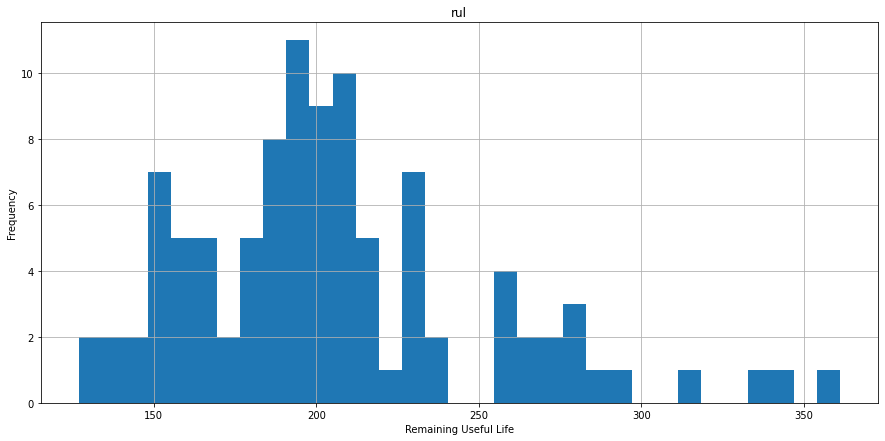

In [6]:
rul = train[['id', 'rul']].groupby('id').max()
rul.hist(bins=33, figsize=(15,7))
plt.xlabel('Remaining Useful Life')
plt.ylabel('Frequency')
plt.show()

In [17]:
train[['id', 'rul']].groupby('id').max()

rul
id      
1    191
2    286
3    178
4    188
5    268
..   ...
96   335
97   201
98   155
99   184
100  199

[100 rows x 1 columns]

In [26]:
from scipy import stats

In [32]:
x = train[['id', 'rul']].groupby('id').max()

In [29]:
x = x - x.min()

In [33]:
stats.weibull_min.fit(x, floc = 0)

(4.389852517646969, 0, 223.9992597681255)

In [1]:
def plts(s):
    plt.figure(figsize=(15,5))
    for i in train['id'].unique():
        plt.plot('rul', s, data=train[train['id'] == i])
    plt.xlim(375, 0)
    plt.xticks(np.arange(0, 400, 25))
    plt.ylabel(s)
    plt.xlabel('Remaining Useful Life')
    plt.show()

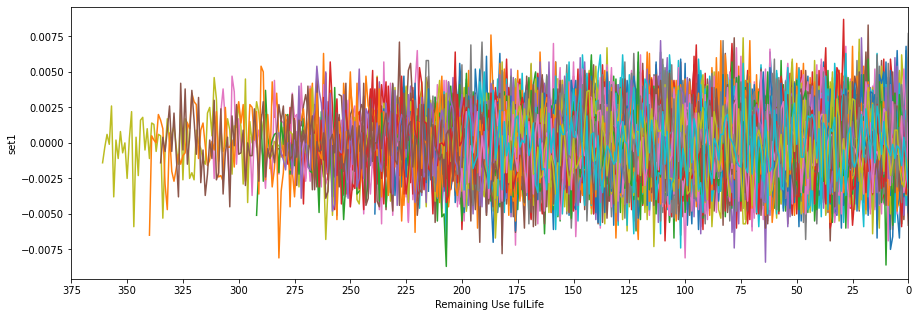

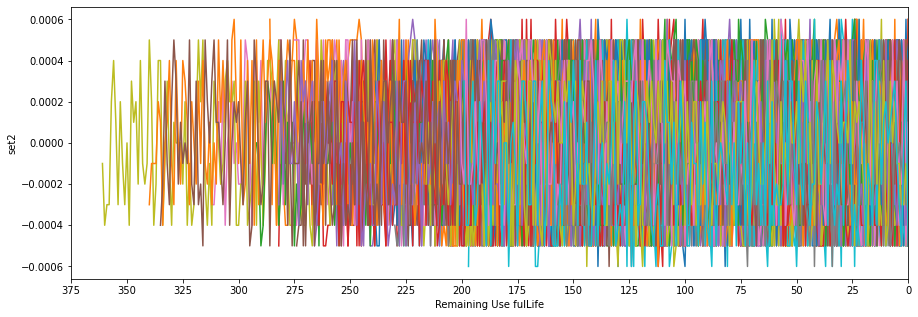

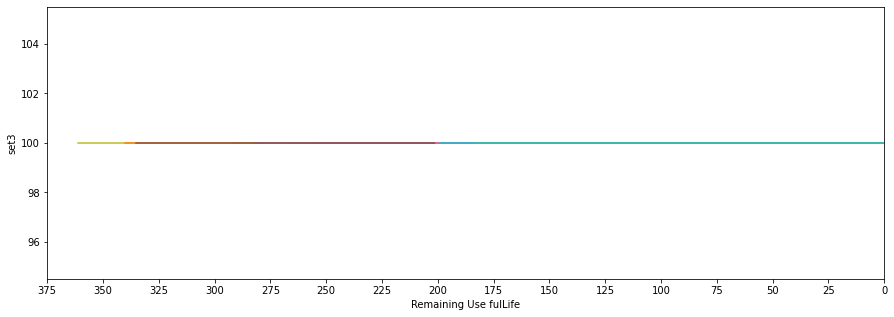

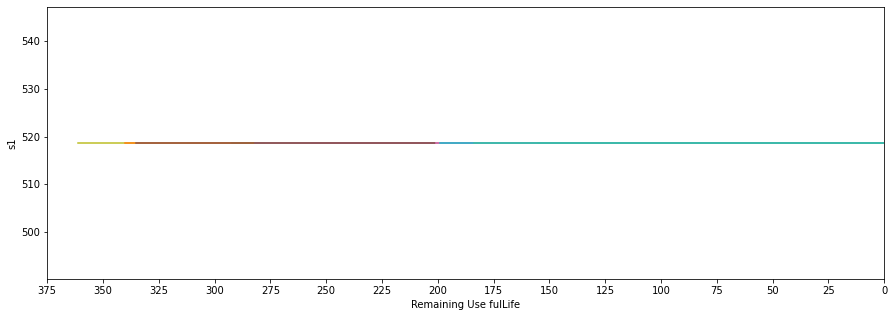

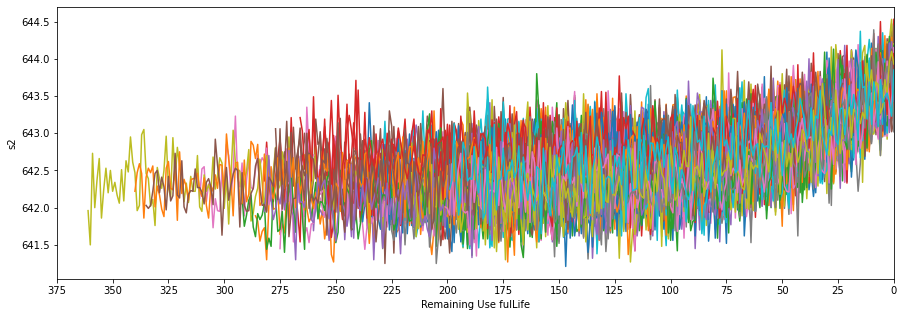

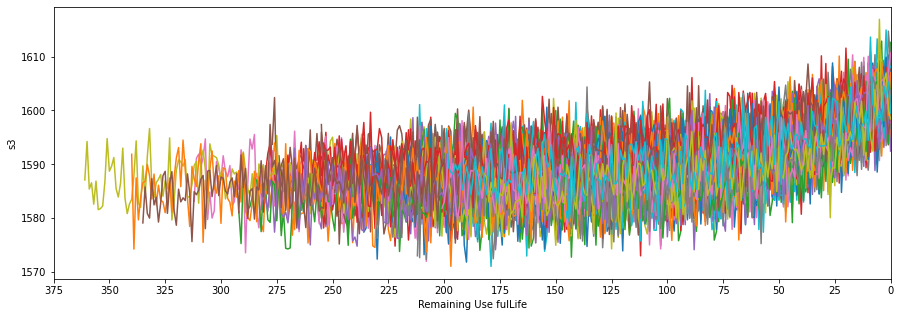

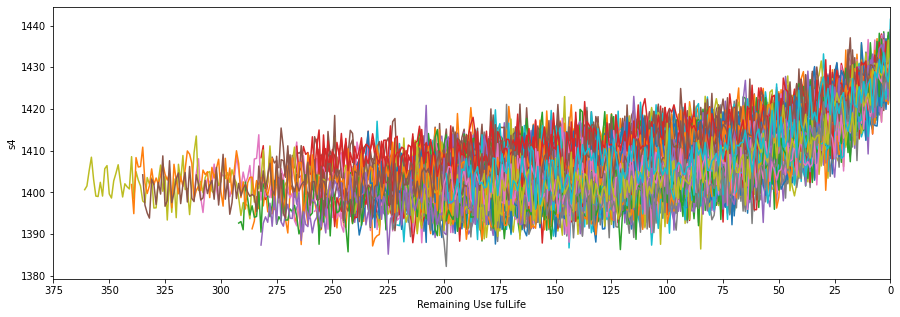

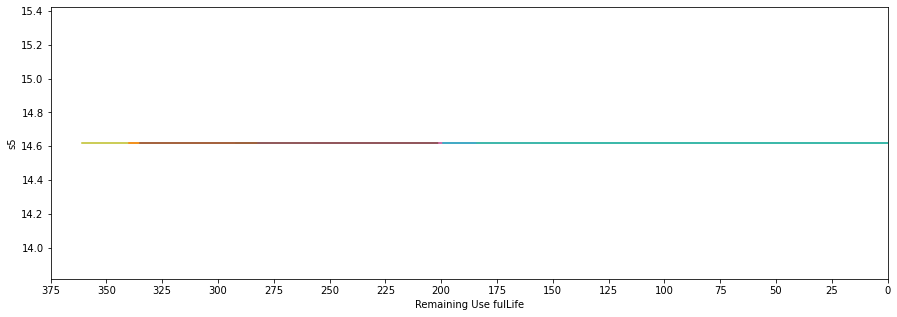

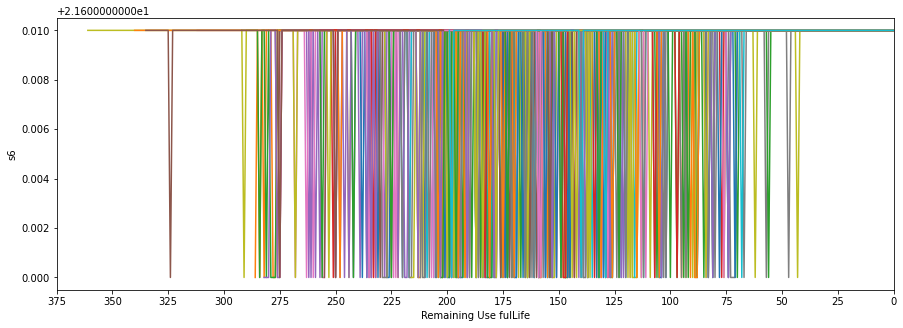

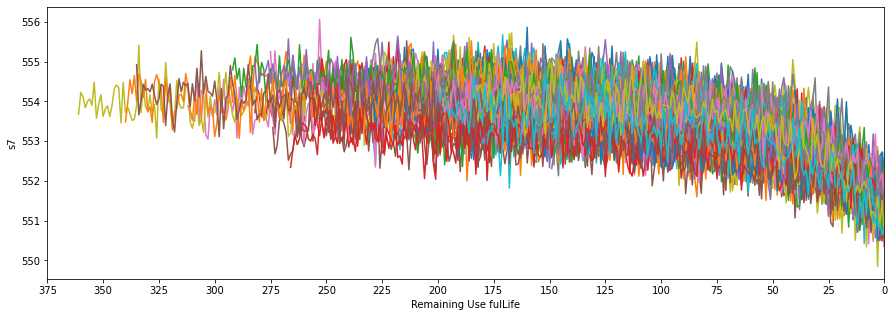

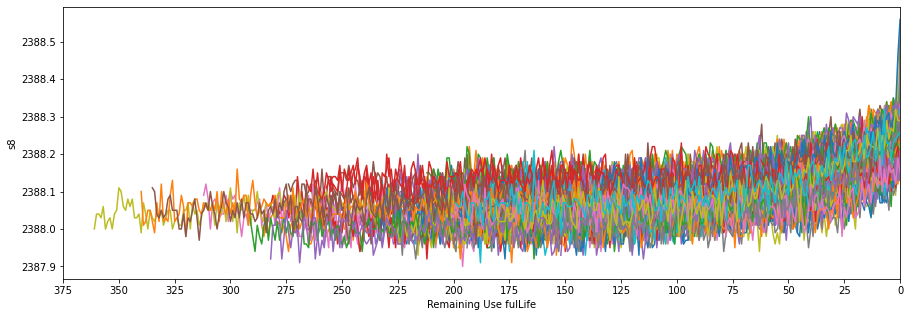

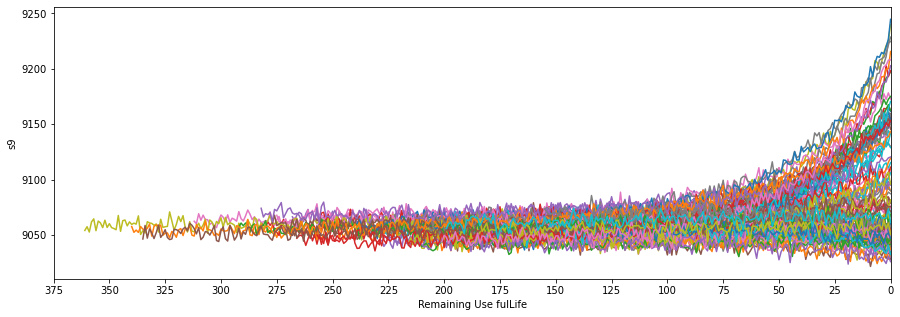

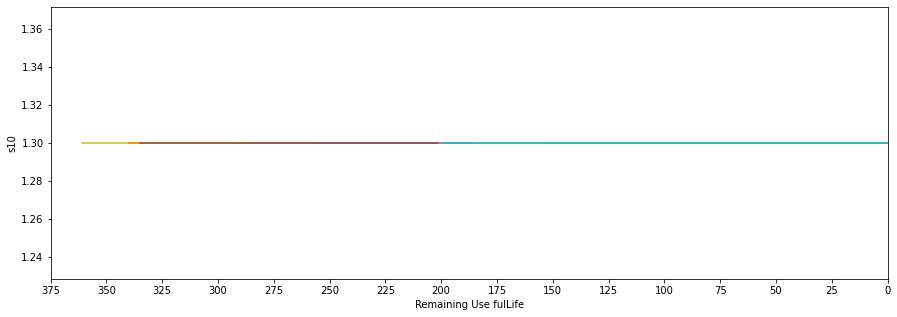

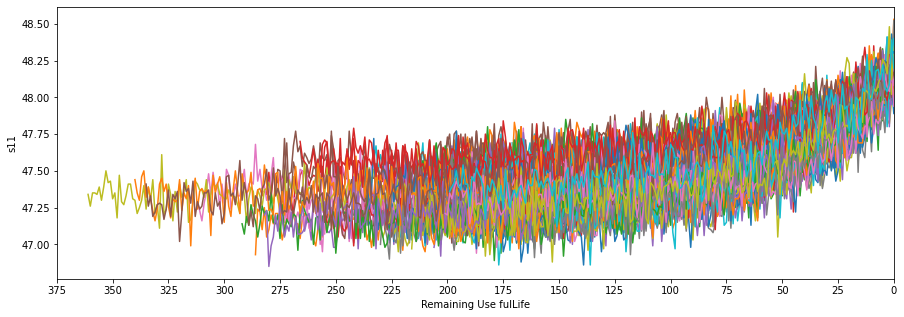

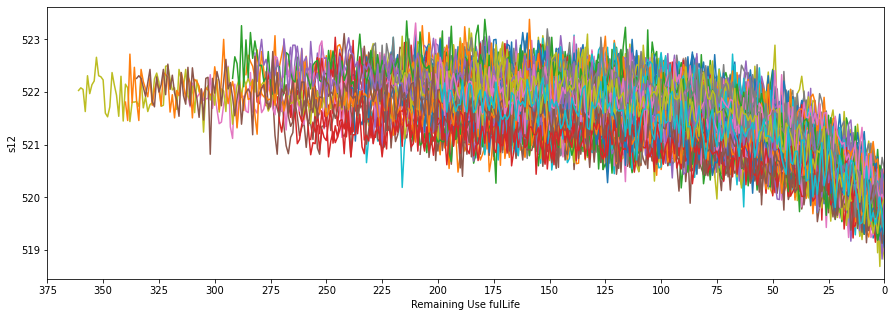

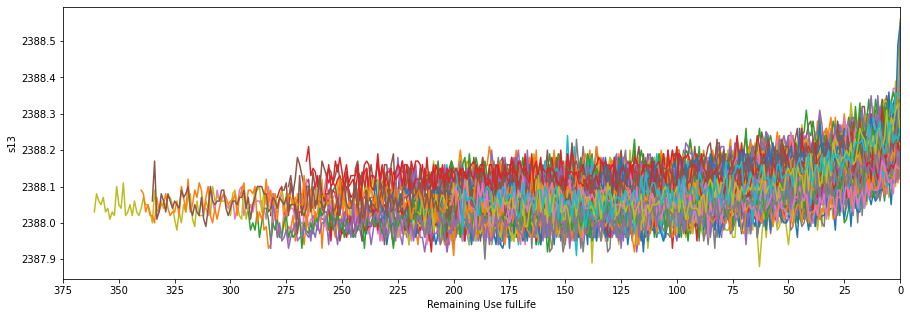

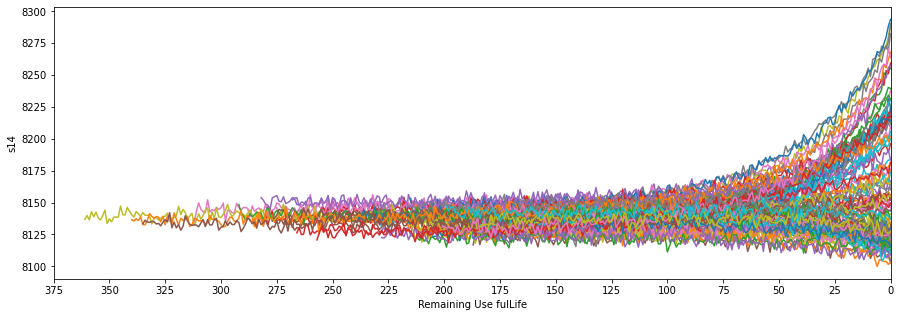

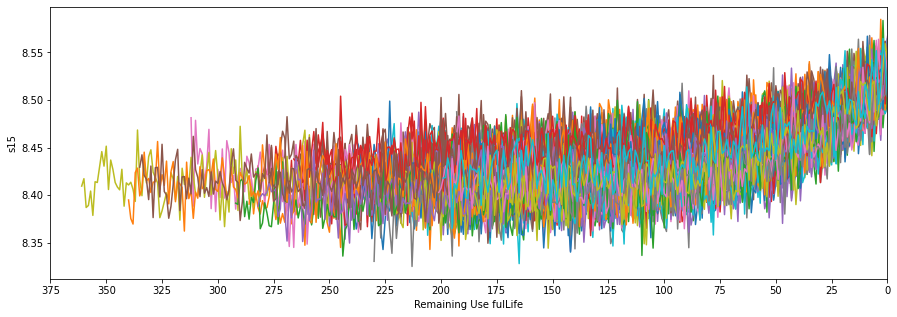

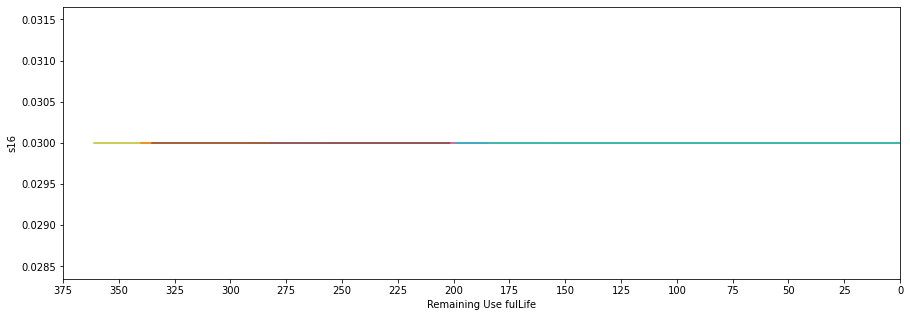

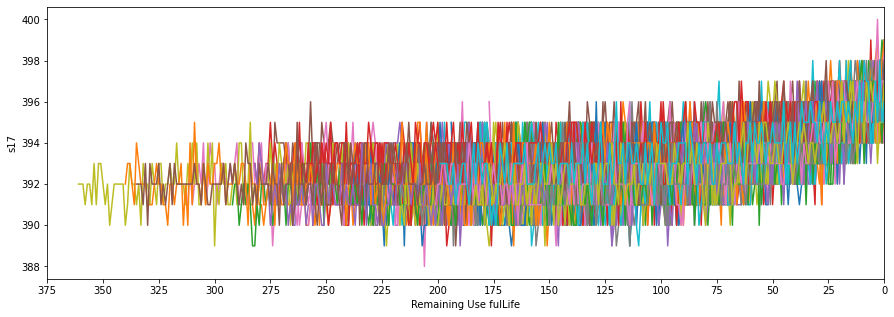

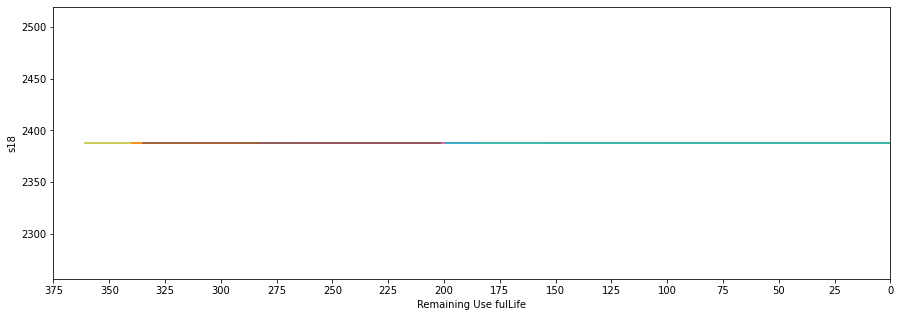

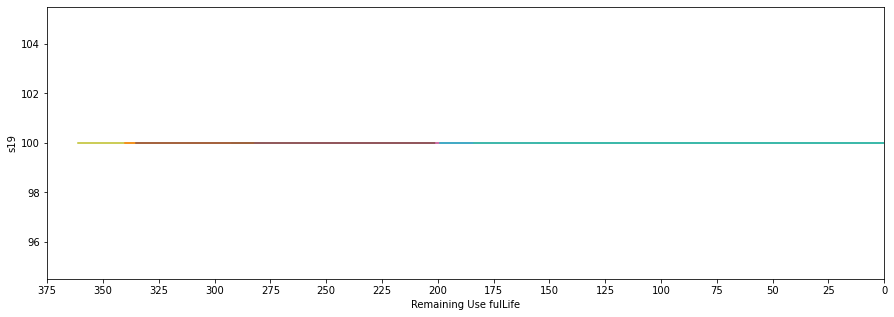

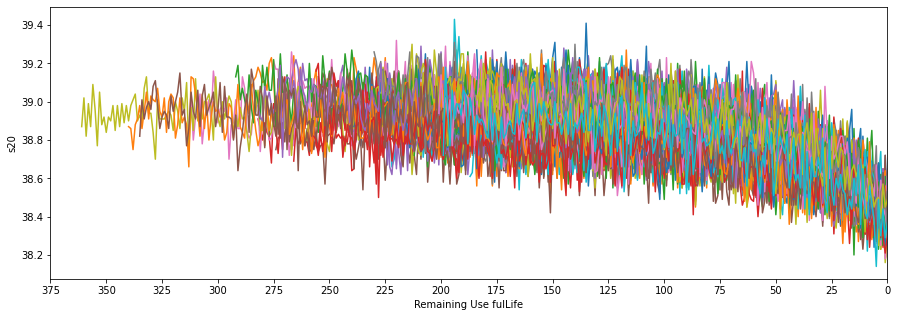

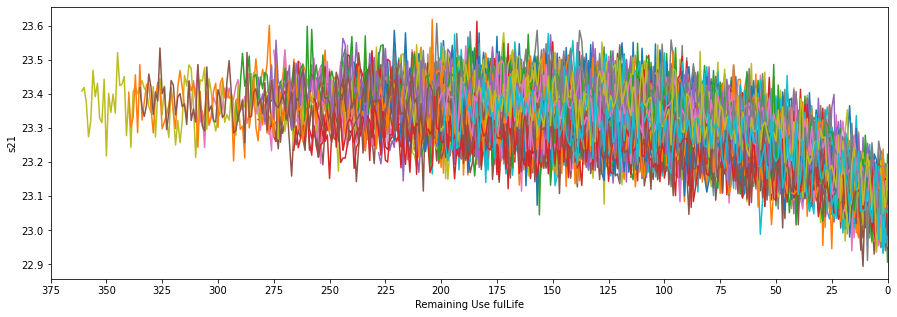

In [8]:
cols = train.columns
cols = cols.drop(['id', 'dt', 'rul', 'rulfrac'])
for s in cols:
    plts(s)

In [9]:
drops = ['dt', 'set1', 'set2', 'set3', 's1', 's5', 's6', 's10', 's16', 's18', 's19']
train = train.drop(columns = drops)
test = test.drop(columns = drops)

In [10]:
trbs = train.drop(columns = ['id', 'rulfrac'])

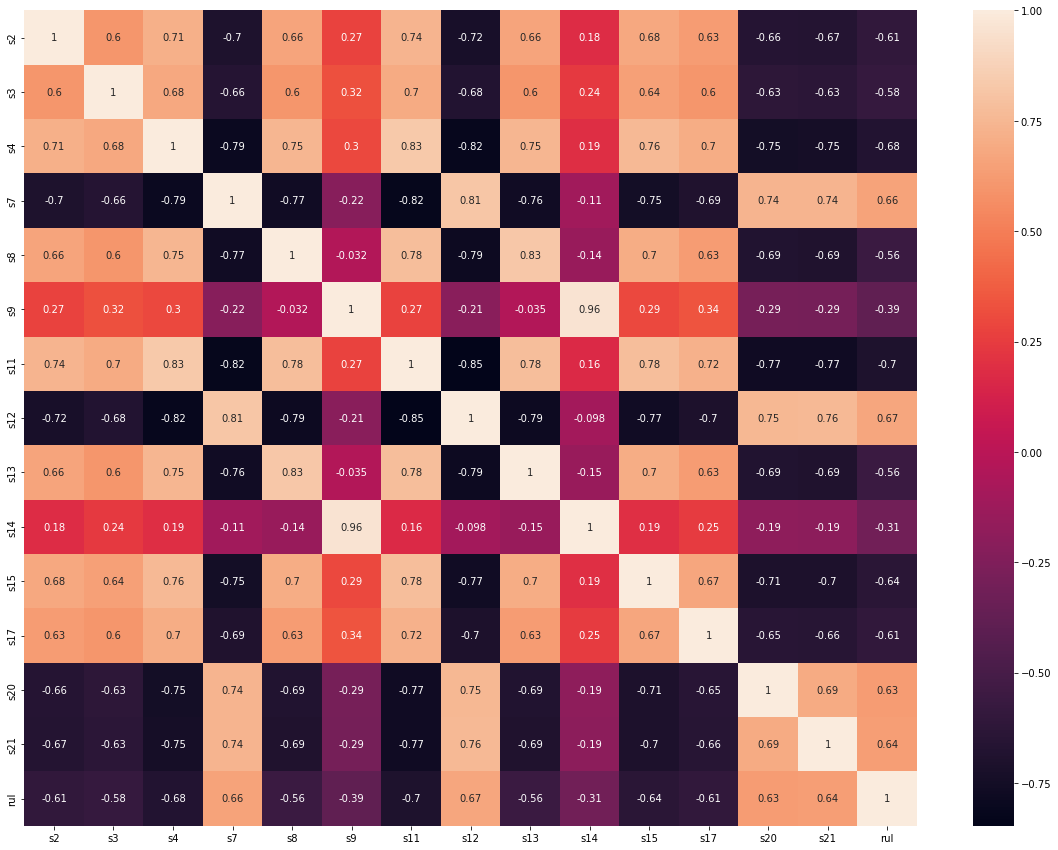

In [11]:
corrmat = trbs.corr()
plt.subplots(figsize = (20 , 15))
sns.heatmap(corrmat, annot = True)
plt.show()

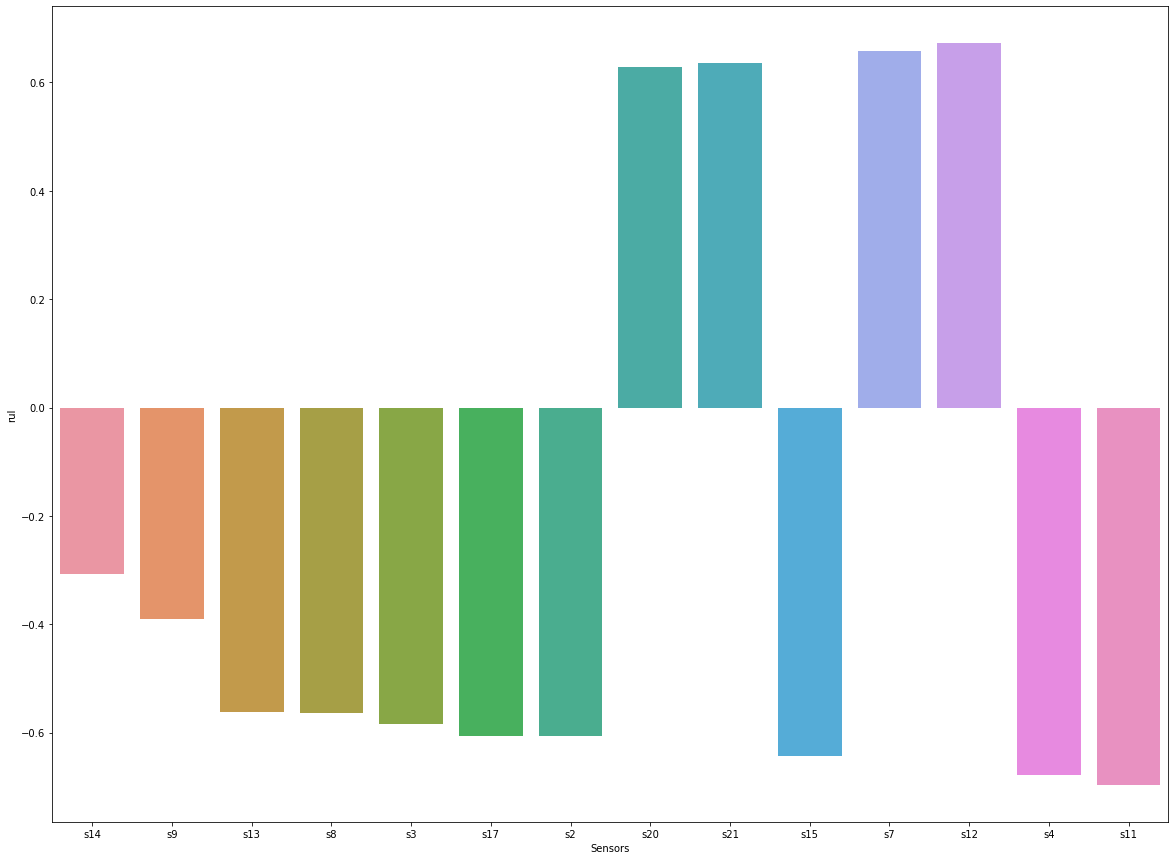

In [12]:
corrrul = corrmat['rul']
corrrul = corrrul.drop(index = ['rul'])
corrrul = corrrul.reindex(corrrul.abs().sort_values().index)
names = corrrul.index
plt.subplots(figsize = (20 , 15))
plt.ylabel('Correlation with RUL')
plt.xlabel('Sensors')
sns.barplot(x = names, y = corrrul)
plt.show()

## Regression Analysis
### Basic Linear Regression

In [13]:
# fit rul or rulfrac
rul = 2
rulfrac = 1

# prepare for fit
r, c = train.shape
Xtrain_base = train.iloc[:, 1:(c - rul)].values
Ytrain_base = train.iloc[:, (c - rul)].values
temp = test.groupby('id').last().reset_index()
r, c = temp.shape
Xtest = temp.iloc[:, 1:(c- rul)].values
Ytest = temp.iloc[:, (c - rul)].values
lm = linear_model.LinearRegression()
lm.fit(Xtrain_base, Ytrain_base)

Next, prepare testing data. This data will be the same for all models

In [14]:
# prepare for prediction
temp = test.groupby('id').last().reset_index()
r, c = temp.shape
Xtest = temp.iloc[:, 1:(c- rul)].values
Ytest = temp.iloc[:, (c - rul)].values
lm = linear_model.LinearRegression()
lm.fit(Xtrain_base, Ytrain_base)
Ypred_lm = lm.predict(Xtest)

In [16]:
lm = linear_model.LinearRegression()
lm.fit(Xtrain_base, Ytrain_base)

LinearRegression()

In [17]:
Ypred_base = lm.predict(Xtrain_base)

In [18]:
print("Training:")
print("Sqrt mse: %.2f" % np.sqrt(mean_squared_error(Ytrain_base, Ypred_base)))
print("Coefficient of determination: %.2f" % r2_score(Ytrain_base, Ypred_base))

Training:
Sqrt mse: 44.67
Coefficient of determination: 0.58


In [19]:
Ypred_lm = lm.predict(Xtest)

In [20]:
print("Testing:")
print("Sqrt mse: %.2f" % np.sqrt(mean_squared_error(Ytest, Ypred_lm)))
print("Coefficient of determination: %.2f" % r2_score(Ytest, Ypred_lm))

Testing:
Sqrt mse: 31.95
Coefficient of determination: 0.41


### Regression with 'Clipped Maxrul'

In [44]:
maxrul = 125
trainclipped = getTFData(sets = [1], testing = False, maxrul = maxrul)

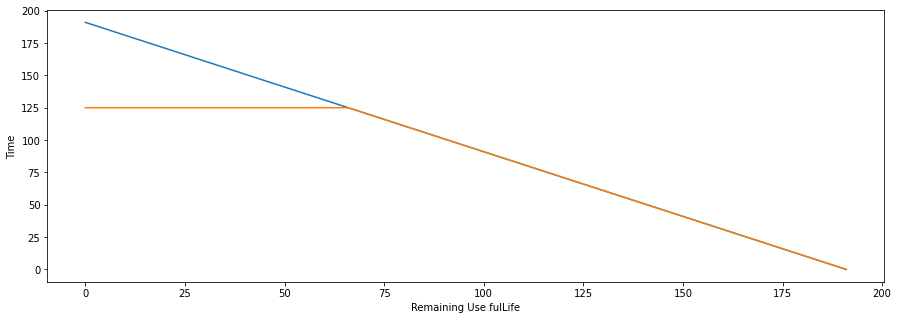

In [46]:
plt.figure(figsize=(15,5))
plt.plot(train['rul'][train['id'] == 1])
plt.plot(trainclipped['rul'][trainclipped['id'] == 1])
plt.ylabel('Time')
plt.xlabel('Remaining Use fulLife')
plt.show()

In [23]:
r, c = trainclipped.shape
Ytrain_clipped = trainclipped.iloc[:, (c - rul)].values

In [26]:
clm = linear_model.LinearRegression()
clm.fit(Xtrain_base, Ytrain_clipped)
Ypred_clipped = clm.predict(Xtrain_base)
print("Training:")
print("Sqrt mse: %.2f" % np.sqrt(mean_squared_error(Ytrain_clipped, Ypred_clipped)))
print("Coefficient of determination: %.2f" % r2_score(Ytrain_clipped, Ypred_clipped))
Ypred_clm = clm.predict(Xtest)
print("Testing:")
print("Sqrt mse: %.2f" % np.sqrt(mean_squared_error(Ytest, Ypred_clm)))
print("Coefficient of determination: %.2f" % r2_score(Ytest, Ypred_clm))

Training:
Sqrt mse: 21.49
Coefficient of determination: 0.73
Testing:
Sqrt mse: 21.90
Coefficient of determination: 0.72


### SVR
First, with default $\epsilon = 0.1$

In [27]:
svr = svm.SVR(kernel='linear')
svr.fit(Xtrain_base, Ytrain_clipped)
Ypred_svr_clipped = svr.predict(Xtrain_base)
print("Training:")
print("Sqrt mse: %.2f" % np.sqrt(mean_squared_error(Ytrain_clipped, Ypred_svr_clipped)))
print("Coefficient of determination: %.2f" % r2_score(Ytrain_clipped, Ypred_svr_clipped))
Ypred_svr = svr.predict(Xtest)
print("Testing:")
print("Sqrt mse: %.2f" % np.sqrt(mean_squared_error(Ytest, Ypred_svr)))
print("Coefficient of determination: %.2f" % r2_score(Ytest, Ypred_svr))

Training:
Sqrt mse: 29.58
Coefficient of determination: 0.50
Testing:
Sqrt mse: 29.68
Coefficient of determination: 0.49


Scaling can help since SVR sensitive to scale of outliers.

In [29]:
scaler = MinMaxScaler()
scaler.fit(Xtrain_base)
Xtrain_sc = scaler.transform(Xtrain_base)
Xtest_sc = scaler.transform(Xtest)

scsvr = svm.SVR(kernel = 'linear')
scsvr.fit(Xtrain_sc, Ytrain_clipped)

Ypred_scsvr_clipped = scsvr.predict(Xtrain_sc)
print("Training:")
print("Sqrt mse: %.2f" % np.sqrt(mean_squared_error(Ytrain_clipped, Ypred_scsvr_clipped)))
print("Coefficient of determination: %.2f" % r2_score(Ytrain_clipped, Ypred_scsvr_clipped))
Ypred_scsvr = scsvr.predict(Xtest_sc)
print("Testing:")
print("Sqrt mse: %.2f" % np.sqrt(mean_squared_error(Ytest, Ypred_scsvr)))
print("Coefficient of determination: %.2f" % r2_score(Ytest, Ypred_scsvr))

Training:
Sqrt mse: 21.58
Coefficient of determination: 0.73
Testing:
Sqrt mse: 21.58
Coefficient of determination: 0.73


#### Basic Polynomial Features
Second degree polynomial features and selection.

In [30]:
poly = PolynomialFeatures(2)
Xtrain_tf = poly.fit_transform(Xtrain_sc)
Xtest_tf = poly.fit_transform(Xtest_sc)

In [36]:
Xtrain_tf.shape

(20631, 120)

In [31]:
svr_tf = svm.SVR(kernel = 'linear')
svr_tf.fit(Xtrain_tf, Ytrain_clipped)

SVR(kernel='linear')

In [33]:
select_features = SelectFromModel(svr_tf, threshold = 'mean', prefit = True)
# select_features.get_support()

In [37]:
svr_sf = svm.SVR(kernel='linear')
svr_sf.fit(Xtrain_tf[:, select_features.get_support()], Ytrain_clipped)

SVR(kernel='linear')

In [39]:
Ypred_sft = svr_sf.predict(Xtrain_tf[:, select_features.get_support()])
print("Training:")
print("Sqrt mse: %.2f" % np.sqrt(mean_squared_error(Ytrain_clipped, Ypred_sft)))
print("Coefficient of determination: %.2f" % r2_score(Ytrain_clipped, Ypred_sft))
Ypred_sf = svr_sf.predict(Xtest_tf[:, select_features.get_support()])
print("Testing:")
print("Sqrt mse: %.2f" % np.sqrt(mean_squared_error(Ytest, Ypred_sf)))
print("Coefficient of determination: %.2f" % r2_score(Ytest, Ypred_sf))

Training:
Sqrt mse: 19.75
Coefficient of determination: 0.78
Testing:
Sqrt mse: 20.56
Coefficient of determination: 0.76


This will be the first benchmark. Further improvements could be obtained by hyperparameter optimization of $\epsilon$.